### Описание проекта:
В рамках проекта у нас была поставлена задача создать решение для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней. Мы работали с информацией по трём интернет-магазинам различных категорий и анализировали обезличенную историю покупок клиентов за определенный период. Проект включал предсказание как на статичных данных, так и на временных рядах с использованием моделей keras, включающих слой LSTM.

In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from keras.models import Model
from keras.layers import LSTM, Dense, Masking, Input, Concatenate, Reshape
from keras.metrics import AUC
from keras.utils import pad_sequences, plot_model, set_random_seed
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.offsets import Day
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE


warnings.filterwarnings("ignore")

In [133]:
MASK_VALUE = -1
set_random_seed(42)
np.random.seed(42)

In [134]:
is_holiday_22_23 = pd.to_datetime([
    "2022-01-01", "2022-01-02", "2022-01-03", "2022-01-04", "2022-01-05", "2022-01-06", "2022-01-08", "2022-01-07",
    "2022-02-23", "2022-03-08", "2022-05-01", "2022-05-02", "2022-05-09", "2022-06-12", "2022-06-13", "2022-11-04",
    "2023-01-01", "2023-01-02", "2023-01-03", "2023-01-04", "2023-01-05", "2023-01-06", "2023-01-08", "2023-01-07",
    "2023-02-23", "2023-03-08", "2023-05-01", "2023-05-09", "2023-06-12", "2023-11-04", "2023-02-24", "2023-05-08",
    "2023-11-06"
])

- marketplace - мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц;
- apparel - магазин одежды, по характеристикам похожий на маркетплейс;
- gifts – магазин подарков, очень маленький;
- client_id – идентификатор клиента;
- quantity – количество товара в заказе;
- price – цена 1 единицы товара в заказе;
- message_id – идентификатор сообщения из рассылки;
- date – дата покупки;

🔸изучить предоставленные данные
🔸создать полезные признаки для обучения модели
🔸создать целевой признак
🔸предложить и обосновать метрику
🔸обучить модель
🔸протестировать и проверить

In [135]:
data_apparel_purchases = pd.read_csv('D:\\\Masterskaya\\market_place\\data\\apparel-purchases.csv')
data_gifts_purchases = pd.read_csv('D:\\\Masterskaya\\market_place\\data\\gifts-purchases.csv')
data_marketplace_purchases = pd.read_csv('D:\\\Masterskaya\\market_place\\data\\marketplace-purchases.csv')

In [136]:
print(data_apparel_purchases.shape)
data_apparel_purchases.head(1)

(133104, 6)


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


### Функция для визуализации количества и объема продаж, а так же числа покупателей 

In [137]:
def plot_sales_statistics(data):
    # Преобразование столбца 'created_at' в тип datetime
    data['date'] = pd.to_datetime(data['date'])

    # Извлечение месяца из столбца 'created_at'
    data['month'] = data['date'].dt.to_period('M')

    # Группировка данных по месяцам и подсчет числа продаж
    sales_per_month = data.groupby('month').size().reset_index(name='count')

    # Группировка данных по месяцам и вычисление суммы цен продаж
    total_sales_per_month = data.groupby('month')['price'].sum().reset_index(name='total_price')
    
    plt.style.use('dark_background')
    plt.rcParams.update({"grid.linewidth":0.3, "grid.alpha":0.5})
    # Создание общего рисунка и подграфиков
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Построение графика числа продаж по месяцам
    sns.barplot(x='month', y='count', data=sales_per_month, color='skyblue', ax=ax1)
    ax1.set_title('Количество  продаж за месяц')
    ax1.set_xticklabels(sales_per_month['month'], rotation=45)
    ax1.set_xlabel('Месяц')
    ax1.set_ylabel('Количество продаж')

    # Построение графика суммарной стоимости продаж по месяцам
    sns.barplot(x='month', y='total_price', data=total_sales_per_month, color='salmon', ax=ax2)
    ax2.set_title('Ежемесячный объем продаж')
    ax2.set_xticklabels(total_sales_per_month['month'], rotation=45)
    ax2.set_xlabel('Месяц')
    ax2.set_ylabel('Сумма продаж за месяц')
    
    data['date'] = pd.to_datetime(data['date'])
    data['month'] = data['date'].dt.to_period('M')

    # Найдем новых клиентов для каждого месяца
    first_purchase_per_customer = data.groupby('client_id')['month'].min().reset_index()
    new_customers_per_month = first_purchase_per_customer.groupby('month').size().reset_index(name='new_customers')
    #new_customers_per_month = data.drop_duplicates('client_id').groupby('month').size().reset_index(name='new_customers')

    # Найдем общее количество клиентов для каждого месяца
    total_customers_per_month = data.groupby('month')['client_id'].nunique().reset_index(name='total_customers')

    # Объединим данные по новым и общим клиентам
    customers_data = pd.merge(total_customers_per_month, new_customers_per_month, on='month')

    sns.set_color_codes("pastel")
    sns.barplot(x='month', y='new_customers', data=customers_data, label='Новые покупатели', color='b', alpha=0.7, ax=ax3)

    sns.set_color_codes("muted")
    sns.barplot(x='month', y='total_customers', data=customers_data, label='Всего покупателей', color='b', alpha=0.7, ax=ax3)

    ax3.set_title('Уникальные покупатели и новые покупатели')
    ax3.set_xticklabels(total_sales_per_month['month'], rotation=45)
    ax3.set_xlabel('Месяц')
    ax3.set_ylabel('Количество покупателей')
    ax3.legend(loc='upper left', frameon=False)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4)  # Увеличиваем расстояние между подграфиками
    plt.show()



In [138]:
data_apparel_purchases['recommended_by'].value_counts()

recommended_by
bulk_message    133104
Name: count, dtype: int64

(133104, 6)


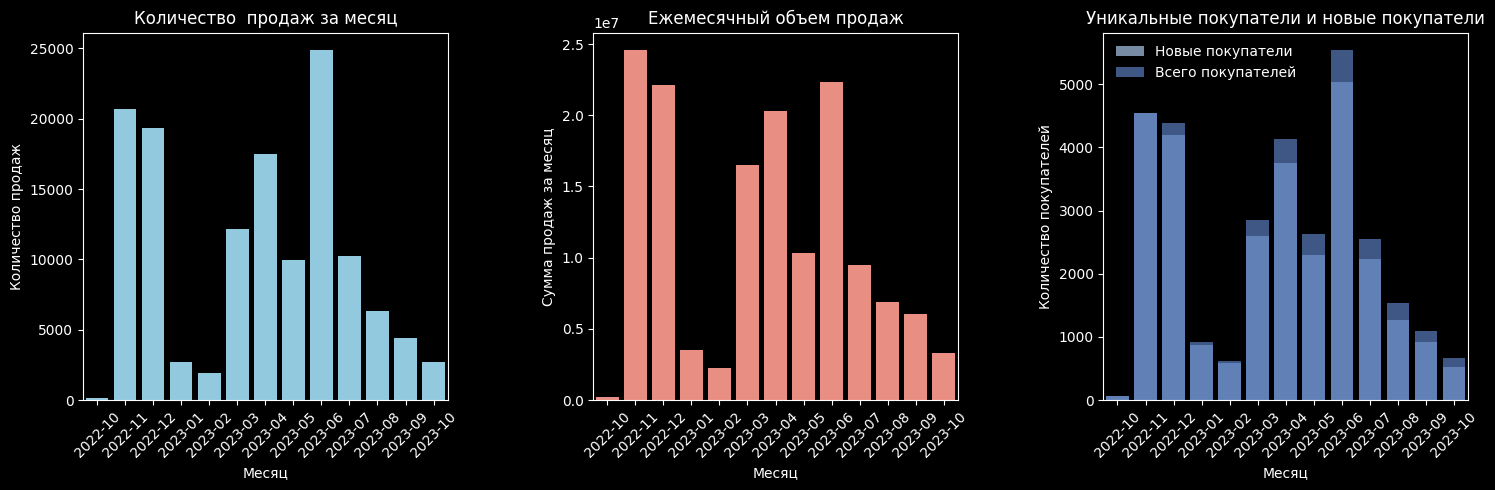

,client_id,quantity,price,date,message_id,recommended_by,month
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message,2023-09


In [139]:
print(data_apparel_purchases.shape)
plot_sales_statistics(data_apparel_purchases)
data_apparel_purchases.head(1)

(811, 6)


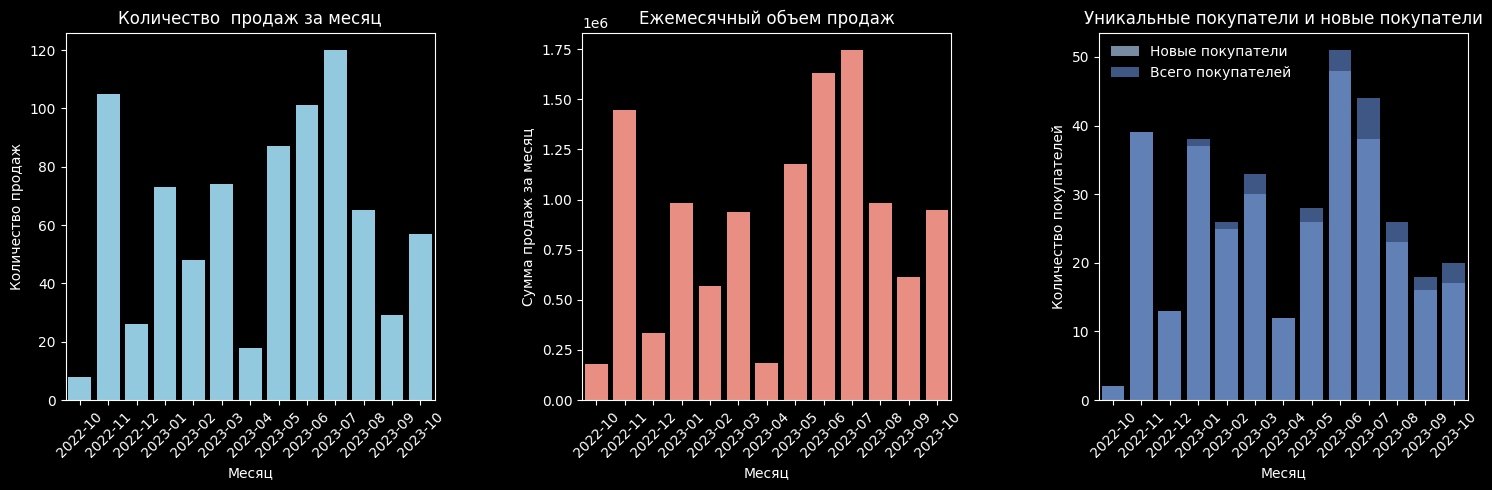

,client_id,quantity,price,date,message_id,recommended_by,month
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message,2023-10


In [140]:
print(data_gifts_purchases.shape)
plot_sales_statistics(data_gifts_purchases)
data_gifts_purchases.head(1)

(48182, 6)


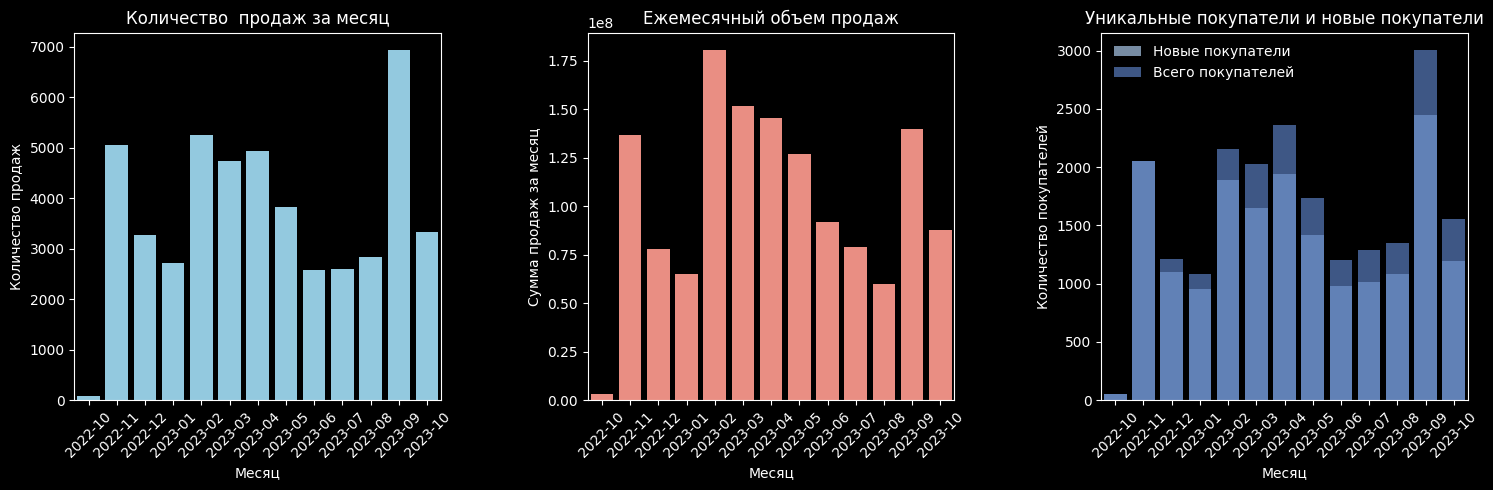

,client_id,quantity,price,message_id,created_at,date,month
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57,2023-05


In [141]:
print(data_marketplace_purchases.shape)
plot_sales_statistics(data_marketplace_purchases)
data_marketplace_purchases.head(1)

In [142]:
# Объединим таблицы и добавить колонку категории магазина.

data_apparel_purchases['store_category_id'] = 1
data_marketplace_purchases['store_category_id'] = 2
data_gifts_purchases['store_category_id'] = 3

# Объединение таблиц
combined_data = pd.concat([data_apparel_purchases, data_marketplace_purchases, data_gifts_purchases], ignore_index=True).copy()

(182097, 8)


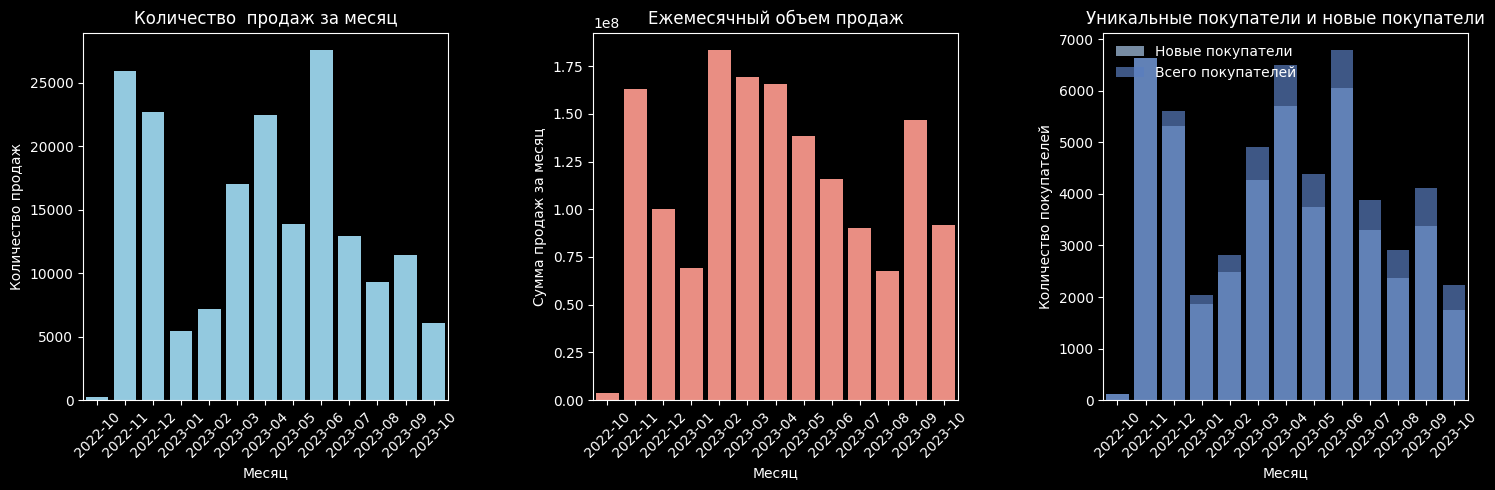

,client_id,quantity,price,date,store_category_id,created_at,message_id_encoded,total,month
42188,1515915625558655965,1,767.0,2022-10-26,1,NaN,30102,767.0,2022-10


In [196]:
print(combined_data.shape)
plot_sales_statistics(combined_data)
combined_data.head(1)

In [143]:
combined_data['message_id'].value_counts().sum

<bound method Series.sum of message_id
1515915625489095763-6251-6311b13a4cf78     271
1515915625624308268-7803-636dfea7ca890     218
1515915625557752721-1909-64942a0b0e7f5     180
1515915625880116527-8725-639b2f0ad5e2e     160
1515915625607113301-13818-650a8af70fd67    148
                                          ... 
1515915625536120644-1985-64b8c802294a5       1
1515915625685286173-8033-637dbe2e0c234       1
1515915625536533267-1965-64abd0808d6c9       1
1515915625536556344-1964-64a54c3f45b1f       1
1515915625524007589-2141-651bad036f2f8       1
Name: count, Length: 46708, dtype: int64>

Сделаем категориальный признак из message_id и закодируем в числовой формат

In [144]:
# Кодирование message_id в числовой формат
encoder = LabelEncoder()
combined_data['message_id_encoded'] = encoder.fit_transform(combined_data['message_id'])

# Удаление исходного столбца message_id
combined_data.drop('message_id', axis=1, inplace=True)

In [145]:
combined_data['recommended_by'].value_counts()

recommended_by
bulk_message    133915
Name: count, dtype: int64

In [146]:
# recommended_by не несет смысла, drop
combined_data = combined_data.drop(columns=['recommended_by','month'])

In [147]:
combined_data[combined_data.duplicated()]

,client_id,quantity,price,date,store_category_id,created_at,message_id_encoded
1,1515915625468068833,1,3499.0,2023-09-08,1,NaN,1363
2,1515915625468068833,1,3499.0,2023-09-08,1,NaN,1363
4,1515915625468068833,1,2450.0,2023-09-08,1,NaN,1363
5,1515915625468068833,1,2450.0,2023-09-08,1,NaN,1363
10,1515915625468079941,1,1499.0,2023-09-01,1,NaN,1474
...,...,...,...,...,...,...,...
182079,1515915625862783809,1,5194.0,2022-11-08,3,NaN,44023
182080,1515915625862783809,1,5194.0,2022-11-08,3,NaN,44023
182081,1515915625862783809,1,5194.0,2022-11-08,3,NaN,44023
182084,1515915625864817073,1,1893.0,2022-11-11,3,NaN,44106


Будем считать, что дубликаты это множественные заказы или различные товары в один день.     
Агрегируем - объединим данные для дубликатов, суммируем количество и цену товаров. 

### Модель времянного ряда

In [148]:
data_grouped = combined_data.groupby(['client_id', 'date', 'store_category_id']).agg({'quantity': 'sum', 'price': 'sum', 'message_id_encoded': 'first'}).reset_index()
data_grouped.shape

(65576, 6)

In [149]:
# Сортировка данных по клиенту и дате
data_grouped = data_grouped.sort_values(['client_id', 'date'])

Создадим временные признаки, например, RFM (Recency, Frequency, Monetary) нарастающим итогом:

In [150]:
# Рассчитаем RFM нарастающим итогом
data_grouped['monetary'] = data_grouped.groupby('client_id')['price'].cumsum()
data_grouped['recency'] = data_grouped.groupby('client_id')['date'].diff().dt.days.fillna(999).astype(int)
data_grouped['frequency'] = data_grouped.groupby('client_id')['date'].cumcount() + 1

Рассчитаем разницу в датах для каждого клиента и получим количество дней до следующей покупки с помощью сдвига:

In [151]:
# data_grouped['days_to_next_purchase'] = data_grouped.groupby('client_id')['date'].diff().dt.days
data_grouped['days_to_next_purchase'] = -data_grouped.sort_values('date', ascending=False).groupby('client_id')['date'].diff().dt.days

Создадим целевую переменную, где 1 означает повторную покупку в течение 30 дней после заказа:

In [152]:
data_grouped['target'] = (data_grouped['days_to_next_purchase'] <= 30).astype(int)

In [153]:
data_grouped = data_grouped.sort_values(['date'])

In [154]:
# Найдем дату, на которую нужно удалить последние 30 дней
date_to_exclude = data_grouped['date'].max() - pd.Timedelta(days=30)

# Удалим данные за последние 30 дней
data_grouped = data_grouped[data_grouped['date'] < date_to_exclude]

In [155]:
data_grouped['frequency'].value_counts()

frequency
1      44678
2       8305
3       3016
4       1461
5        858
       ...  
120        1
121        1
122        1
123        1
144        1
Name: count, Length: 144, dtype: int64

In [156]:
# Скопировать data_grouped в features_time_s
features_time_s = data_grouped.copy()

# Создание признаков "день месяца", "день недели", "неделя месяца" и "является ли день выходным"
features_time_s['total_price'] = features_time_s['price'] * features_time_s['quantity']
features_time_s['day_of_month'] = features_time_s['date'].dt.day
features_time_s['day_of_week'] = features_time_s['date'].dt.dayofweek
features_time_s['month'] = features_time_s['date'].dt.month
features_time_s['week_of_year'] = features_time_s['date'].dt.isocalendar().week
features_time_s['week_of_month'] = features_time_s['date'].apply(lambda x: (x.day - 1) // 7 + 1)
features_time_s['is_weekend'] = features_time_s['day_of_week'].isin([5, 6]).astype(int)
features_time_s['is_holiday'] = features_time_s['date'].isin(is_holiday_22_23).astype(int)

# Создаем список дат на следующие 30 дней от каждой даты в features_time_s
date_ranges = [pd.date_range(date, periods=30) for date in features_time_s['date']]
# Создаем новый признак 'holidays_next_30_days'
features_time_s['holidays_next_30_days'] = [sum(1 for holiday in is_holiday_22_23 if holiday in date_range) for date_range in date_ranges]



In [157]:
features_time_s.head(3)

,client_id,date,store_category_id,quantity,price,message_id_encoded,monetary,recency,frequency,days_to_next_purchase,target,total_price,day_of_month,day_of_week,month,week_of_year,week_of_month,is_weekend,is_holiday,holidays_next_30_days
53849,1515915625587818098,2022-10-26,1,2,17998.0,9575,17998.0,999,1,NaN,0,35996.0,26,2,10,43,4,0,0,1
54008,1515915625588327029,2022-10-26,1,1,2499.0,37963,2499.0,999,1,NaN,0,2499.0,26,2,10,43,4,0,0,1
10138,1515915625489888679,2022-10-26,1,3,2213.0,9134,2213.0,999,1,NaN,0,6639.0,26,2,10,43,4,0,0,1


In [158]:
# Определяем целевой признак
X = features_time_s.drop(['date', 'client_id', 'days_to_next_purchase', 'target', 'total_price'], axis=1)
y = features_time_s['target']

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [159]:
# # Сетка параметров для подбора
# grid = {'learning_rate': [0.15],
#         'depth': [10],
#         'l2_leaf_reg': [1, 2, 3],}

# # Инициализация модели CatBoost с использованием GPU
# model = CatBoostClassifier(iterations=1000, task_type='GPU', devices='0:1', verbose=False) 

# # Подбор лучших параметров с помощью Grid Search
# grid_search_result = model.grid_search(grid, X=Pool(X_train, label=y_train), plot=True)

# # Получение лучших параметров
# best_params = grid_search_result['params']

# # Создание модели с лучшими параметрами и использованием GPU
# best_model = CatBoostClassifier(iterations=1000, task_type='GPU', devices='0:1', verbose=False, **best_params)

In [160]:
best_params = {'depth': 10, 'l2_leaf_reg': 2, 'learning_rate': 0.15}

{'depth': 10, 'l2_leaf_reg': 2, 'learning_rate': 0.15}

In [161]:
# # Определение числа признаков, которые хотим оставить после RFE
# n_features_to_select = 5  # Вы можете выбрать желаемое количество признаков

# # Создание RFE с CatBoostClassifier
# rfe = RFE(estimator=best_model, n_features_to_select=n_features_to_select)

# # Обучение RFE
# rfe.fit(X_train, y_train)

# # Получение ранжированного списка признаков
# print("Ранжированные признаки:")
# for i in range(len(X.columns)):
#     if rfe.support_[i]:
#         print(X.columns[i])

In [162]:
best_model = CatBoostClassifier(iterations=1000, verbose=False, **best_params)

In [163]:
# Обучение модели на всей обучающей выборке
best_model.fit(X_train, y_train)

In [164]:
# # Обучение модели CatBoost с кросс-валидацией
# model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=0, loss_function='Logloss')

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc')

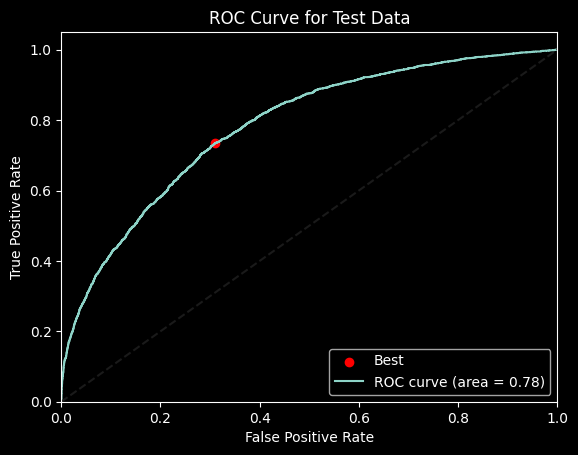

best threshold 0.134
ROC AUC на тестовой выборке: 0.7819876913323676


In [165]:
y_pred = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)

# Построение ROC-AUC кривой для тестового набора данных
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
idx = np.argmax(tpr - fpr)
best_thresh = thresholds[idx]
plt.figure()
plt.scatter(fpr[idx], tpr[idx], marker="o", color="red", label="Best")
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data. Модель времянного ряда.')
plt.legend(loc="lower right")
plt.show()

# Предсказываем на тестовой выборке и вычисляем ROC AUC
y_pred_class = best_model.predict(X_test)
roc_auc_test = roc_auc_score(y_test, y_pred)
print('best threshold', best_thresh.round(3))
print(f'ROC AUC на тестовой выборке: {roc_auc_test}')

In [166]:
# Важность признаков
feature_importance = best_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print('Важность признаков:')
print(feature_importance_df)

Важность признаков:
                  Feature  Importance
3      message_id_encoded   16.489356
4                monetary   11.895679
7            day_of_month   11.710404
2                   price   11.501480
10           week_of_year   10.956223
8             day_of_week    9.644241
1                quantity    8.285575
5                 recency    4.512586
0       store_category_id    4.314623
6               frequency    3.048661
14  holidays_next_30_days    2.368136
9                   month    2.248764
11          week_of_month    1.563532
12             is_weekend    1.299608
13             is_holiday    0.161130


In [167]:
report = classification_report(y_test, y_pred > best_thresh, output_dict=True)
df_report = pd.DataFrame(report).round(2)
print(df_report)

                 0        1  accuracy  macro avg  weighted avg
precision     0.91     0.39       0.7       0.65          0.80
recall        0.69     0.73       0.7       0.71          0.70
f1-score      0.78     0.51       0.7       0.65          0.73
support    9716.00  2582.00       0.7   12298.00      12298.00


### Попробуем совместить получившуюся модель с keras 

In [168]:
data_grouped_seq = combined_data

# Добавляем поле total
data_grouped_seq['total'] = data_grouped_seq['price'] * data_grouped_seq['quantity']

data_grouped_seq = data_grouped_seq.sort_values(by='date')

# Группировка и добавление поля since_prev_purchase
data_grouped_seq['since_prev_purchase'] = (data_grouped_seq.groupby('client_id')['date'].diff().dt.days.fillna(0).astype(int))

# Выборка нужных столбцов
data_grouped_seq = data_grouped_seq[['client_id','date', 'message_id_encoded', 'total', 'since_prev_purchase']]

In [169]:

scaler = MinMaxScaler(feature_range=(0, 1))

features_to_scale = ['total', 'since_prev_purchase']
scaled_names = [f'{col}_scaled' for col in features_to_scale]
data_grouped_seq[scaled_names] = scaler.fit_transform(data_grouped_seq[features_to_scale])

features_seq = (data_grouped_seq.groupby(['client_id', 'date'])[scaled_names]
                  .agg(list).add_suffix('_seq').reset_index())

features_seq.head()


,client_id,date,total_scaled_seq,since_prev_purchase_scaled_seq
0,1515915625440099873,2023-07-16 08:25:31,[0.022727918447131557],[0.0]
1,1515915625440099873,2023-08-09 08:59:08,[0.0008651354668606237],[0.06760563380281691]
2,1515915625440939402,2023-01-30 13:13:37,[0.05398075961451041],[0.0]
3,1515915625440944408,2023-03-01 10:21:12,[0.0006264774070370033],[0.0]
4,1515915625440944408,2023-05-02 08:49:57,[0.004473418038003455],[0.17183098591549298]


In [170]:
# Удалим данные за последние 30 дней
features_seq = features_seq[features_seq['date'] < date_to_exclude]

In [171]:
features_seq.shape

(61487, 4)

In [172]:
pad_sequence = lambda x: pad_sequences(x.values, dtype=float, value=MASK_VALUE, padding='post')
reshape = lambda x: x.reshape(x.shape + (1,))
to_drop_names = ['client_id','date']
X_seq = np.concatenate([
    reshape(pad_sequence(features_seq[col]))
    for col in features_seq.drop(to_drop_names, axis=1).columns
], axis=2)

X_seq.shape

(61487, 216, 2)

In [173]:
scaler_time_s = MinMaxScaler(feature_range=(1, 9))
X_time_s = scaler_time_s.fit_transform(features_time_s.drop(['client_id','days_to_next_purchase','date', 'target'], axis=1))
X_time_s.shape

(61487, 16)

In [174]:
y = data_grouped['target']
display(data_grouped['target'].value_counts().to_frame().assign(percentage=lambda x: x/x.sum()).style.format({'percentage':'{:.2%}', 'target':'{:.0f}'}).set_caption('Распределение классов'))
y = y.values

y.shape

,count,percentage
target,,
0,48579,79.01%
1,12908,20.99%


(61487,)

In [175]:
X_train_seq, X_test_seq, X_train_time_s, X_test_time_s, y_train, y_test = train_test_split(
    X_seq, X_time_s, y, test_size=0.2, random_state=42)

In [176]:
input_seq = Input(shape=(X_train_seq.shape[1:]))
input_time_s = Input(shape=X_train_time_s.shape[1:])

print(input_seq.shape, input_time_s.shape)

(None, 216, 2) (None, 16)


In [177]:
# Apply Masking layer to input_seq
module_seq = Masking(mask_value=MASK_VALUE)(input_seq)
module_seq = LSTM(16)(module_seq)

# Apply Dense layer to input_fix
module_fix = Dense(16, activation='relu')(input_time_s)

# Reshape module_seq to fit the second dimension of module_fix
reshaped_module_seq = Reshape(target_shape=(16,))(module_seq)

# Concatenate the outputs
merged = Concatenate()([reshaped_module_seq, module_fix])

# Define the output layer
output = Dense(1, activation='sigmoid')(merged)

# Create the model
model = Model(inputs=[input_seq, input_time_s], outputs=output)
model.compile(loss='binary_crossentropy', metrics=[AUC()])

In [178]:
model.fit(x=[X_train_seq, X_train_time_s], y=y_train, validation_split=0.25, epochs=3, batch_size=32)

Epoch 1/3
1153/1153 [==============================] - 55s 45ms/step - loss: 0.4355 - auc_2: 0.7643 - val_loss: 0.4229 - val_auc_2: 0.7834
Epoch 2/3
1153/1153 [==============================] - 52s 45ms/step - loss: 0.4185 - auc_2: 0.7849 - val_loss: 0.4201 - val_auc_2: 0.7882
Epoch 3/3
1153/1153 [==============================] - 51s 44ms/step - loss: 0.4162 - auc_2: 0.7870 - val_loss: 0.4157 - val_auc_2: 0.7912


385/385 [==============================] - 5s 11ms/step


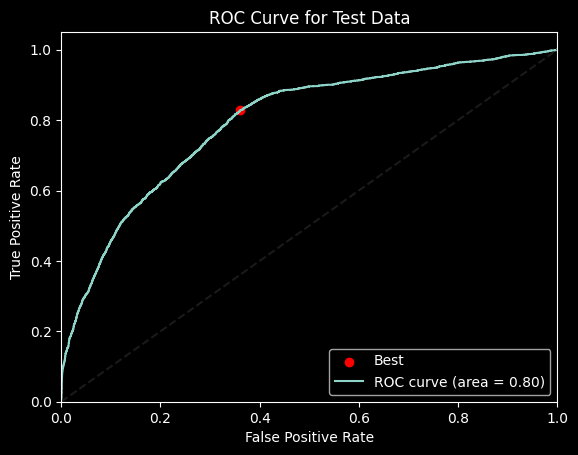

roc auc score 0.796
best threshold 0.208


,0,1,accuracy,macro avg,weighted avg
precision,0.93,0.38,0.68,0.66,0.82
recall,0.64,0.83,0.68,0.73,0.68
f1-score,0.76,0.52,0.68,0.64,0.71
support,9687.00,2611.00,0.68,12298.00,12298.00


In [179]:
y_pred = model.predict((X_test_seq, X_test_time_s)).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

idx = np.argmax(tpr - fpr)
best_thresh = thresholds[idx]

plt.figure()
plt.scatter(fpr[idx], tpr[idx], marker="o", color="red", label="Best")
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred).round(3))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data. Keras со слоем LSTM')
plt.legend(loc="lower right")
plt.show()

print('roc auc score', roc_auc_score(y_test, y_pred).round(3))
print('best threshold', best_thresh.round(3))
pd.DataFrame(classification_report(y_test, y_pred>(best_thresh), output_dict=True)).round(2)

### Статическая модель

In [188]:
# Сортируем данные по дате
combined_data = combined_data.sort_values('date')

# Ищем последние 30 дней в данных о покупках
data_last_30_days = combined_data[combined_data['date'] >= combined_data['date'].max() - pd.DateOffset(days=30)]

# Исключаем последние 30 дней из других данных
data_wo_last_30_days = combined_data[combined_data['date'] < combined_data['date'].max() - pd.DateOffset(days=30)]

# Создание основных признаков
grouped_data_static = data_wo_last_30_days.groupby(['client_id', 'store_category_id'])
current_date = data_wo_last_30_days['date'].max()
features_static = grouped_data_static.agg(
    days_since_first_purchase=('date', lambda x: (current_date - x.min()).days),
    days_since_last_purchase=('date', lambda x: (current_date - x.max()).days),
    days_between_purchases_min=('date', lambda x: (x.max() - x.min()).days if len(x) > 1 else -999),
    days_between_purchases_mean=('date', lambda x: x.diff().dt.days.sum() / (len(x) - 1) if len(x) > 1 else -999),
    days_between_purchases_max=('date', lambda x: x.diff().dt.days.max() if len(x) > 1 else -999),
    total_products_bought=('quantity', 'sum'),
    total_purchases=('date', 'nunique'),
    average_purchase_price=('price', 'mean'),
    max_purchase_price=('price', 'max'),
    min_purchase_price=('price', 'min'),
    total_spent=('price', 'sum'),
    preferred_day_of_week=('date', lambda x: x.dt.dayofweek.mode()[0]),
    preferred_week_of_year=('date', lambda x: x.dt.isocalendar().week.mode()[0]),
    preferred_week_of_month=('date', lambda x: np.ceil(x.dt.day / 7).mode()[0]),                        
    most_common_message_id=('message_id_encoded', lambda x: x.value_counts().idxmax())).reset_index()

# Присвоение таргета
target_client_ids = data_last_30_days['client_id'].unique()
features_static['target'] = features_static['client_id'].isin(target_client_ids).astype(int)

# Вывод полученных признаков
features_static

,client_id,store_category_id,days_since_first_purchase,days_since_last_purchase,days_between_purchases_min,days_between_purchases_mean,days_between_purchases_max,total_products_bought,total_purchases,average_purchase_price,max_purchase_price,min_purchase_price,total_spent,preferred_day_of_week,preferred_week_of_year,preferred_week_of_month,most_common_message_id,target
0,1515915625440099873,2,72,48,24,24.000000,24.0,2,2,16608.000000,31998.0,1218.0,33216.0,2,28,2.0,0,0
1,1515915625440939402,2,239,239,-999,-999.000000,-999.0,1,1,75998.000000,75998.0,75998.0,75998.0,0,5,5.0,2,0
2,1515915625440944408,2,209,97,112,55.500000,61.0,3,3,27059.333333,73998.0,882.0,81178.0,2,9,1.0,3,0
3,1515915625440947454,2,323,275,47,15.666667,47.0,4,2,1121.500000,3998.0,2.0,4486.0,5,44,1.0,6,0
4,1515915625440952940,2,319,319,-999,-999.000000,-999.0,1,1,479.000000,479.0,479.0,479.0,4,45,2.0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44673,1515915625996380624,3,27,27,0,0.000000,0.0,6,1,11708.500000,33732.0,4040.0,70251.0,2,35,5.0,46689,0
44674,1515915625997511191,3,39,39,-999,-999.000000,-999.0,1,1,15043.000000,15043.0,15043.0,15043.0,4,33,3.0,46698,0
44675,1515915625997770678,3,39,39,0,0.000000,0.0,5,1,20835.400000,47549.0,1909.0,104177.0,4,33,3.0,46699,0
44676,1515915626005014483,3,13,13,-999,-999.000000,-999.0,1,1,7534.000000,7534.0,7534.0,7534.0,2,37,2.0,45265,0


In [189]:
# Отделяем целевую переменную от признаков
X = features_static.drop(['client_id', 'target'], axis=1)
y = features_static['target']

# Разбиваем на обучающую и тестовую выборки
X_train_static, X_test_static, y_train_static, y_test_static = train_test_split(X, y, test_size=0.2, random_state=42)

In [190]:
display(features_static['target'].value_counts().to_frame().assign(percentage=lambda x: x/x.sum()).style.format({'percentage':'{:.2%}', 'target':'{:.0f}'}).set_caption('Распределение классов'))
X.shape, y.shape

,count,percentage
target,,
0,44023,98.53%
1,655,1.47%


((44678, 16), (44678,))

In [191]:
model_static = CatBoostClassifier(iterations=1500)  # best_params - параметры из предыдущих шагов
model_static.fit(X_train_static, y_train_static)

Learning rate set to 0.032709
0:	learn: 0.6211392	total: 10.5ms	remaining: 15.7s
1:	learn: 0.5583156	total: 19.7ms	remaining: 14.7s
2:	learn: 0.4988759	total: 28.6ms	remaining: 14.3s
3:	learn: 0.4505440	total: 37.3ms	remaining: 13.9s
4:	learn: 0.4094137	total: 45.8ms	remaining: 13.7s
5:	learn: 0.3728729	total: 54.8ms	remaining: 13.6s
6:	learn: 0.3396285	total: 63.5ms	remaining: 13.5s
7:	learn: 0.3107071	total: 71.7ms	remaining: 13.4s
8:	learn: 0.2845736	total: 80.3ms	remaining: 13.3s
9:	learn: 0.2603342	total: 89.6ms	remaining: 13.3s
10:	learn: 0.2399890	total: 96.2ms	remaining: 13s
11:	learn: 0.2211314	total: 105ms	remaining: 13.1s
12:	learn: 0.2053178	total: 115ms	remaining: 13.1s
13:	learn: 0.1914252	total: 124ms	remaining: 13.1s
14:	learn: 0.1776750	total: 133ms	remaining: 13.2s
15:	learn: 0.1656702	total: 142ms	remaining: 13.2s
16:	learn: 0.1558792	total: 151ms	remaining: 13.2s
17:	learn: 0.1468785	total: 160ms	remaining: 13.2s
18:	learn: 0.1384513	total: 170ms	remaining: 13.3s
19

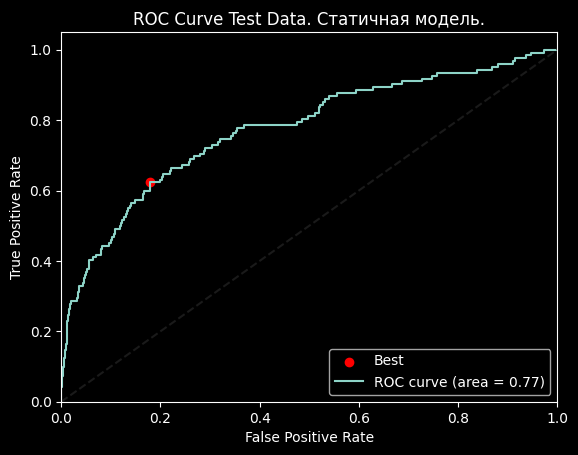

best threshold 0.014
ROC-AUC на тестовой выборке: 0.7733960874465735


In [195]:
# Предсказать вероятности для тестовой выборки
y_pred_static = model_static.predict_proba(X_test_static)[:, 1]
# Построение ROC-AUC кривой для тестового набора данных
fpr, tpr, thresholds = roc_curve(y_test_static, y_pred_static)
idx = np.argmax(tpr - fpr)
best_thresh = thresholds[idx]
# Вычислить ROC-AUC
roc_auc = roc_auc_score(y_test_static, y_pred_static)
plt.figure()
plt.scatter(fpr[idx], tpr[idx], marker="o", color="red", label="Best")
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Test Data. Статичная модель.')
plt.legend(loc="lower right")
plt.show()

print('best threshold', best_thresh.round(3))
print("ROC-AUC на тестовой выборке:", roc_auc)

In [193]:
# Важность признаков
feature_importance = model_static.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print('Важность признаков:')
print(feature_importance_df)

Важность признаков:
                        Feature  Importance
15       most_common_message_id   15.253195
1     days_since_first_purchase    9.856310
11                  total_spent    8.574927
2      days_since_last_purchase    8.268713
0             store_category_id    8.229832
9            max_purchase_price    7.823447
10           min_purchase_price    7.388336
8        average_purchase_price    6.988622
13       preferred_week_of_year    6.322362
12        preferred_day_of_week    4.281111
4   days_between_purchases_mean    3.750070
14      preferred_week_of_month    3.257571
7               total_purchases    2.808626
6         total_products_bought    2.548244
5    days_between_purchases_max    2.453815
3    days_between_purchases_min    2.194818


In [194]:
report = classification_report(y_test_static, y_pred_static > best_thresh, output_dict=True)
df_report = pd.DataFrame(report).round(2)
print(df_report)

                 0       1  accuracy  macro avg  weighted avg
precision     0.99    0.05      0.82       0.52          0.98
recall        0.82    0.61      0.82       0.72          0.82
f1-score      0.90    0.08      0.82       0.49          0.89
support    8814.00  122.00      0.82    8936.00       8936.00


### Мои выводы:
Исследование показало, что модель, основанная на keras с LSTM, демонстрирует высокий уровень точности и полноты, особенно в предсказании повторных покупок. Её ROC-AUC составил 0.796, а precision и recall для класса 1 равны 0.38 и 0.83 соответственно. Это говорит о хорошей способности модели выявлять и правильно классифицировать случаи повторных покупок.

В сравнении с моделью временного ряда и статичной моделью, модель с использованием keras и LSTM значительно превосходит по показателям качества классификации. Однако все модели показали определенные успехи в предсказании поведения клиентов.

Рекомендации по дальнейшему развитию проекта включают улучшение качества моделей путем дополнительной тонкой настройки гиперпараметров, использование более широкого спектра временных признаков для повышения точности прогнозов, а также активное использование полученных данных для персонализации маркетинговых стратегий и стимулирования возвращения клиентов.

Проект предоставляет нам ценные инсайты о поведении клиентов и дает нам основание для эффективных действий по увеличению числа возвратных клиентов и оптимизации маркетинговых стратегий.

#### Статичная модель:  
ROC-AUC: 0.773  
Precision для класса 1: 0.05    
Recall для класса 1: 0.61   
F1-score для класса 1: 0.08 
#### Модель keras со слоем LSTM:    
ROC-AUC: 0.796  
Precision для класса 1: 0.38    
Recall для класса 1: 0.83   
F1-score для класса 1: 0.52 
#### Модель временного ряда:    
ROC-AUC: 0.782  
Precision для класса 1: 0.39    
Recall для класса 1: 0.73   
F1-score для класса 1: 0.51 